# Aim
In this notebook, we try out different methods to compute DTW distance to decide on the optimal approach to quantifying kinematic similarity of gestures. In particular, we examine the followings:

1. which preprocessing methods leads to a higher predictive accuracy, z-normalization or position/size normalization.
1. whether original gesture durations lead to better performance compared to adjusted gesture duration (any gestures shorter than 330 ms lengthened to 330ms).
1. whether asymmetric, loose beginning and end DTW works out better than symmetric DTW.
1. whether DTW-dependent works out better than DTW-independent

# 0. Import packages & define directories

In [12]:
# load in packages
import numpy as np                           # basic data operations
import pandas as pd                          # data wrangling
import matplotlib.pyplot as plt              # for plotting
import plotly.graph_objects as go            # for plotting
import html                                  # for html-related add-ons
import os                                    # for foldering       
import glob                                  # for file handling     
from tqdm import tqdm                        # for progress bars
import seaborn as sns                        # for plotting
import itertools                             # for list combinations
import matplotlib.pyplot as plt              # for plotting
import statsmodels.formula.api as smf        # for linear regression
from scipy.stats import spearmanr            # for correlation
from warnings import simplefilter            # for ignoring warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# load custom-made functions
from functions import merge_ts, fill_missing_values, normalize_size, normalize_position, \
    adjust_aspect_ratio, flip_y_axis, export_merge_annot, calculate_relative_position, change_wrist_col_name

from dtw_functions import retrieve_keypoints, retrieve_relative_keypoints, make_export_dtw_df, plot_dtw_sim

# initialize some folders and files
timeseries_folder = "../../data/time_series/"
# list of all the folders in the time series folder
ts_folders = os.listdir(timeseries_folder)

anno_path = "../elan_annotation/"
processed_folder = "../processed/"
merged_folder = processed_folder + "01_merged_ts/"
interpolated_folder = processed_folder + "02_interpolated_ts/"
norm_smooth_folder = processed_folder + "03_normalized_and_smoothed_ts/"
ts_annot_folder = processed_folder + "04_ts_with_anno_for_each_comparison/"
dtw_folder = processed_folder + "05_dtw_distance/"
# ts_annot_adjusted_folder = processed_folder + "06_ts_with_anno_dur_adjusted/"
# dtw_adjusted_folder = processed_folder + "07_dtw_distance_dur_adjusted/"
# modified_folder = processed_folder + "08_modified_ts/"
# ts_annot_modified_folder = processed_folder + "09_ts_with_anno_modified/"
# dtw_modified_folder = processed_folder + "10_dtw_distance_modified/"

# setting up autoreload for interactive development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Z-normalization vs. position/size normalization
First, we will examine the predictive accuracy of DTW based on z-normalized time series data vs. position/size-normalized data.

## Preprocessing
We will perform the following preprocessing on the timeseries data:

1. merge body and hands time series data into one pandas dataframe
2. interpolate the missing values
3. apply smoothing
4. calculate relative finger positions
5. z-normalize or normalize for size and position
6. adjust for aspect ratio
7. flip y axis

**Why do we interpolate missing values?**

Sometimes, mediapipe fails to estimate the location of a joint and returs no value. This leads to a timeseries with a lot of missing values or NaNs and can cause errors when computing distance using DTW.

To tackle this, we will fill out missing values based on the most adjacent values for the particular keypoint. For example, imagine that the "X_LEFT_THUMB_TIP" consisted of 5 missing values like this: 0.5, 0.4, NaN, NaN, NaN, NaN, NaN, -0.2. In this case, we will fill the NaNs in a way that the value immediately before the first NaN and the one immediately after the last NaN are equally distanced, like this: 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2. This can offer a reasonable estimate for where the hand was for the missing points.

**Why do we smooth the data?**

We will apply smoothing because most likely, there will be noise-related jitter in the time series data.

**Why do we use relative finger positions for DTW instead of raw coordinates?**
We use relative finger positions because if we use raw coordinates of each finger tip, difference in location would be penalized 6 times when running DTW.

Imagine a scenario where two speakers produced identical gestures---perfect alignment in handshape, orientation, and movement---but in difference positions. Ideally, we would get a very low DTW distance score, as only the location differs between the gestures. However, computing DTW distance on raw coordinates may return a high distance, because difference in location is not only reflected in the wrists coordinates but also in the coordinates of each finger tip. This means that difference in location is reflected in **6 keypoints**, giving more weights to location. See example below:

<img src="figures/relative_finger_position.svg" height=500 />


One solution to this is to calculate relative finger positions and compute DTW on the wrist and each finger tip. This way, only the wrists contain information about the location of the hands, and finger tips will not be affected by the difference in hand locations. We can comupte the relative location by `finger_tip_loc - wrist_loc`.


**Why do we normalize for size and position?**

We normalize size and position to ensure a consistent representation of poses across different frames and individuals. In other words, normalization reduces noise in the data caused by variation in the location of participant. 

Consider a case where in one video (video A) a participant is standing on the left of the video at 1m from the camera and in another video (video B) the same participant is standing on the right side at 2m from the camera. In this case, values for x-axis is (almost) always lower for video A because of the participant appears on the left in video A while they appear on the right in video B. In addition, the same movements look bigger in video B because the participant is closer to the camera. In this case, applying size and position normalization can "move" the participant to the center of the video so that the difference in standing position does not affect timeseries data.

**Why do we adjust for aspect ratio and flip y-axis?**

We adjust the values for x- and y-axis to align the unit size for x and y. For example, for a video with 16:9 aspect ratio (e.g., 1920:1080), if moving a hand 5 cm horizontally corresponds to 0.1 in x, moving a hand 5 cm vertically corresponds to about 0.18 in y. This difference arises because although the width of video is larger than the height, the range of MediaPipe unit is 0 to 1 for both x and y.

In addition, we will flip the y-axis because mediapipe output unit for y-axis is conterintuitve: 0 means top and 1 means bottom of the frame.

## 1.1 Merge, interpolated, and smooth the data

In [5]:
#load in data
ts_file_list = [timeseries_folder + file_name + "/" + file_name for file_name in ts_folders]
skip_count = 0
existing_files = []
body_cols_to_keep = ["time", 
                     "X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER",
                     "X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER",
                     "X_LEFT_HIP", "Y_LEFT_HIP", "Z_LEFT_HIP",
                     "X_RIGHT_HIP", "Y_RIGHT_HIP", "Z_RIGHT_HIP"]

for file in tqdm(ts_file_list):
    filename = file.split("/")[-1]
    if os.path.exists(interpolated_folder + filename + "_interpolated.csv"):
        skip_count += 1
        existing_files.append(file)
        continue
    
    # merge body and hands time series
    merged_df = merge_ts(file, body_cols_to_keep)
    merged_df.to_csv(merged_folder + filename + "_merged.csv", index=False)
    # interpolate missing values
    interpolated_df = fill_missing_values(merged_df)
    # apply smoothing
    xyz_cols = [col for col in interpolated_df.columns if col.startswith("X_") or col.startswith("Y_") or col.startswith("Z_")]
    smoothed_df = interpolated_df[xyz_cols].apply(lambda x: gaussian_filter1d(x, sigma = 2))
    smoothed_df.insert(0, 'time', interpolated_df["time"])
    # save interpolated and smoothed time series
    smoothed_df.to_csv(interpolated_folder + filename + "_interpolated.csv", index=False)

if skip_count > 0:
    print(f"Skipped {skip_count} files that already exist in the normalized and smoothed folder.")
    print(existing_files)

100%|██████████| 38/38 [00:00<00:00, 2827.85it/s]

Skipped 38 files that already exist in the normalized and smoothed folder.
['../../data/time_series/pair04_synced_ppA/pair04_synced_ppA', '../../data/time_series/pair04_synced_ppB/pair04_synced_ppB', '../../data/time_series/pair05_synced_ppA/pair05_synced_ppA', '../../data/time_series/pair05_synced_ppB/pair05_synced_ppB', '../../data/time_series/pair07_synced_ppA/pair07_synced_ppA', '../../data/time_series/pair07_synced_ppB/pair07_synced_ppB', '../../data/time_series/pair08_synced_ppA/pair08_synced_ppA', '../../data/time_series/pair08_synced_ppB/pair08_synced_ppB', '../../data/time_series/pair09_synced_ppA/pair09_synced_ppA', '../../data/time_series/pair09_synced_ppB/pair09_synced_ppB', '../../data/time_series/pair10_synced_ppA/pair10_synced_ppA', '../../data/time_series/pair10_synced_ppB/pair10_synced_ppB', '../../data/time_series/pair11_synced_ppA/pair11_synced_ppA', '../../data/time_series/pair11_synced_ppB/pair11_synced_ppB', '../../data/time_series/pair12_synced_ppA/pair12_synced_

## 1.2 Z-normalization

In [28]:
#load in data
ts_file_list = [interpolated_folder + file_name for file_name in os.listdir(interpolated_folder)]
keypoints = retrieve_keypoints()
skip_count = 0
existing_files = []

for file in tqdm(ts_file_list):
    filename = file.split("/")[-1].replace("_interpolated.csv", "")
    if os.path.exists(norm_smooth_folder + "z-normalized/" + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue
    
    # load interpolated time series
    interpolated_df = pd.read_csv(file)

    # calculate relative finger positions
    normalized_df = calculate_relative_position(interpolated_df.copy(), keypoints)
    normalized_df = change_wrist_col_name(normalized_df)

    # z-score normalization
    xyz_cols = [col for col in normalized_df.columns if col.startswith("x_") or col.startswith("y_") or col.startswith("z_")]
    normalized_df = (normalized_df[xyz_cols] - normalized_df[xyz_cols].mean()) / normalized_df[xyz_cols].std()

    # flip y-axis
    normalized_df = flip_y_axis(normalized_df)
    
    # insert time column back
    normalized_df.insert(0, 'time', interpolated_df["time"])

    # save normalized and smoothed time series
    normalized_df.to_csv(norm_smooth_folder + "z-normalized/" + filename + "_ns.csv", index=False)

100%|██████████| 38/38 [05:46<00:00,  9.11s/it]


## 1.3 Position/size normalization

In [43]:
#load in data
ts_file_list = [interpolated_folder + file_name for file_name in os.listdir(interpolated_folder)]
keypoints = retrieve_keypoints()
skip_count = 0
existing_files = []

for file in tqdm(ts_file_list):
    filename = file.split("/")[-1].replace("_interpolated.csv", "")
    if os.path.exists(norm_smooth_folder + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue
    
    # load interpolated time series
    interpolated_df = pd.read_csv(file)

    # drop unnecessary columns
    keypoints_to_keep = ["time", "SHOULDER", "HIP", "WRIST", "THUMB_TIP", "INDEX_FINGER_TIP", 
                        "MIDDLE_FINGER_TIP", "RING_FINGER_TIP", "PINKY_FINGER_TIP"]
    cols_to_keep = [col for col in interpolated_df.columns if any(kp in col for kp in keypoints_to_keep)]
    interpolated_df = interpolated_df[cols_to_keep]

    # normalize time series
    normalized_df = normalize_size(interpolated_df.copy())
    normalized_df = normalize_position(normalized_df)

    # calculate relative finger positions
    normalized_df = calculate_relative_position(normalized_df, keypoints)
    normalized_df = change_wrist_col_name(normalized_df)

    # drop unnecessary columns
    xyz_cols = [col for col in normalized_df.columns if col.startswith("x_") or col.startswith("y_") or col.startswith("z_")]
    normalized_df = normalized_df[xyz_cols]
    normalized_df.insert(0, 'time', interpolated_df["time"])

    # adjust for aspect ratio
    normalized_df = adjust_aspect_ratio(normalized_df)

    # flip y-axis
    normalized_df = flip_y_axis(normalized_df)

    # save normalized and smoothed time series
    normalized_df.to_csv(norm_smooth_folder + filename + "_ns.csv", index=False)


if skip_count > 0:
    print(f"Skipped {skip_count} files that already exist in the normalized and smoothed folder.")
    print(existing_files)

100%|██████████| 38/38 [12:54<00:00, 20.38s/it]

Skipped 17 files that already exist in the normalized and smoothed folder.
['../processed/02_interpolated_ts/pair04_synced_ppA_interpolated.csv', '../processed/02_interpolated_ts/pair04_synced_ppB_interpolated.csv', '../processed/02_interpolated_ts/pair05_synced_ppA_interpolated.csv', '../processed/02_interpolated_ts/pair05_synced_ppB_interpolated.csv', '../processed/02_interpolated_ts/pair07_synced_ppA_interpolated.csv', '../processed/02_interpolated_ts/pair07_synced_ppB_interpolated.csv', '../processed/02_interpolated_ts/pair08_synced_ppA_interpolated.csv', '../processed/02_interpolated_ts/pair08_synced_ppB_interpolated.csv', '../processed/02_interpolated_ts/pair09_synced_ppA_interpolated.csv', '../processed/02_interpolated_ts/pair09_synced_ppB_interpolated.csv', '../processed/02_interpolated_ts/pair10_synced_ppA_interpolated.csv', '../processed/02_interpolated_ts/pair10_synced_ppB_interpolated.csv', '../processed/02_interpolated_ts/pair11_synced_ppA_interpolated.csv', '../processed/

## 1.4 Visualize the preprocessing outcomes

In [35]:
pair04_merged = pd.read_csv(merged_folder + "pair04_synced_ppA_merged.csv")
pair04_interpolated = pd.read_csv(interpolated_folder + "pair04_synced_ppA_interpolated.csv")
pair04_normalized_z = pd.read_csv(norm_smooth_folder + "z-normalized/pair04_synced_ppA_ns.csv")
pair04_normalized = pd.read_csv(norm_smooth_folder + "pair04_synced_ppA_ns.csv")

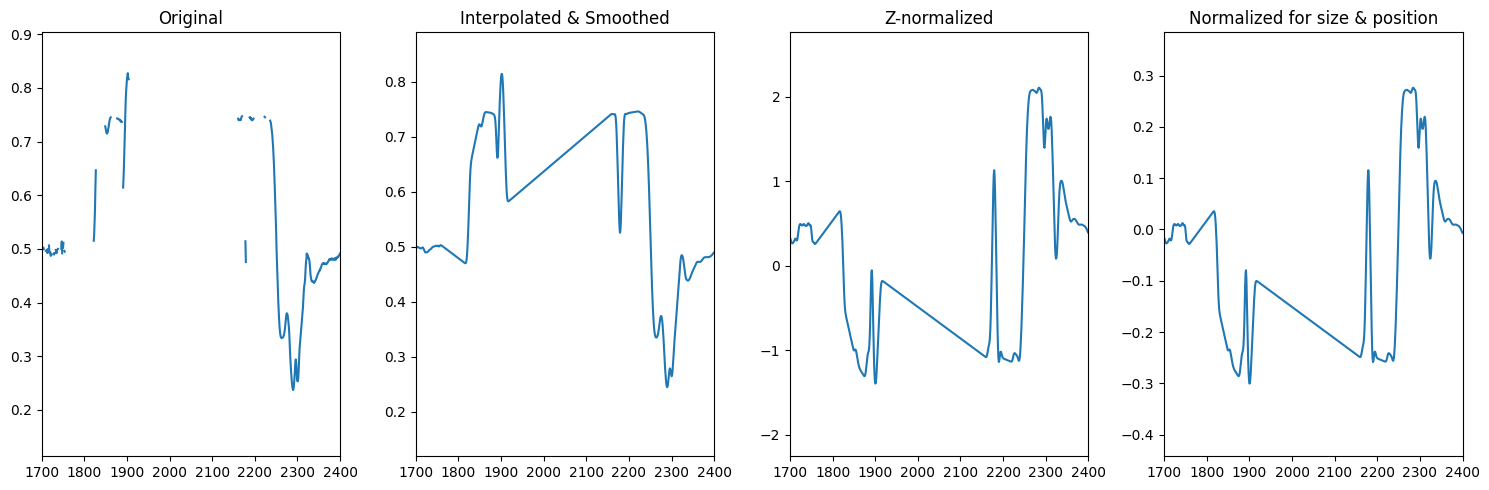

In [36]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.plot(pair04_merged[["Y_LEFT_INDEX_FINGER_TIP"]])
ax1.set_title("Original")
ax1.set_xlim(1700, 2400)
ax2.plot(pair04_interpolated[["Y_LEFT_INDEX_FINGER_TIP"]])
ax2.set_title("Interpolated & Smoothed")
ax2.set_xlim(1700, 2400)
ax3.plot(pair04_normalized_z[["y_left_index_finger_tip_relative"]])
ax3.set_title("Z-normalized")
ax3.set_xlim(1700, 2400)
ax4.plot(pair04_normalized[["y_left_index_finger_tip_relative"]])
ax4.set_title("Normalized for size & position")
ax4.set_xlim(1700, 2400)
plt.tight_layout()

As can be seen in the second plot, the missing values are interpolated linearly. Of course this is not a perfectly accurate estimates for the missing values, but we will use it as a good-enough approximation.

Based on the last figure, it looks like the smoothing was applied successfully. Note that the middle "mountain" observed in the first two plots has disappeared in the last plot. This is not because of smoothing, but because of normalization, suggesting that the body (sholders) moved together with the hand.

## 1.5 Trim time series for gesture duration
Now, let's merge mediapipe pose estimation data with ELAN annotations and trim the time series data for the duration of gestures.

In [44]:
annots = os.listdir(anno_path)

### only for validation
for anno_filename in annots:
    if anno_filename == "gesture_form_similarity_coding_original.csv": # only load in the gesture similarity coding file for validation
        anno = pd.read_csv(anno_path + anno_filename, sep=";")
        # if A_begin_msec is smaller than B_begin_msec, then A is the first gesturer
        anno["speaker_1"] = np.where(anno["A_begin_msec"] < anno["B_begin_msec"], "A", "B")
        # if A_begin_msec is smaller than B_begin_msec, then B is the second gesturer
        anno["speaker_2"] = np.where(anno["A_begin_msec"] < anno["B_begin_msec"], "B", "A")
anno.to_csv(anno_path + "gesture_form_similarity_coding.csv", index=False, sep=";")

# load in the annotations for gesture similarity coding
for anno_filename in annots:
    if anno_filename == "gesture_form_similarity_coding.csv": # only load in the gesture similarity coding file for validation
        anno = pd.read_csv(anno_path + anno_filename, sep=";")
        # create a comparison_id column that starts from 1 and increments by 1. This will be used when computing the distance matrix using DTW
        anno["comparison_id"] = anno.index + 1
        # create handedness, position, shape, movement, and orientation columns and fill them with the values from the gesture_similarity_coding column
        # in the gesture similarity coding column, the values are preceded by the category name (e.g. "H1" for handedness with value 1)
        anno["handedness"] = anno["gesture_similarity_coding"].str.extract(r'H(\d)').astype(int)
        anno["position"] = anno["gesture_similarity_coding"].str.extract(r'P(\d)').astype(int)
        anno["shape"] = anno["gesture_similarity_coding"].str.extract(r'S(\d)').astype(int)
        anno["movement"] = anno["gesture_similarity_coding"].str.extract(r'M(\d)').astype(int)
        anno["orientation"] = anno["gesture_similarity_coding"].str.extract(r'R(\d)').astype(int)
        anno["n_hand_A"] = np.where(anno["A_hands"].str.endswith("both"), 2, 1)
        anno["n_hand_B"] = np.where(anno["B_hands"].str.endswith("both"), 2, 1)
        anno["handedness_one_or_both"] = np.where(anno["n_hand_A"] == anno["n_hand_B"], 1, 0)

        # remove 9 from the handedness, position, shape, movement, and orientation columns
        anno["handedness"] = anno["handedness"].replace(9, 0)
        anno["position"] = anno["position"].replace(9, 0)
        anno["shape"] = anno["shape"].replace(9, 0)
        anno["movement"] = anno["movement"].replace(9, 0)
        anno["orientation"] = anno["orientation"].replace(9, 0)

        # compute the total number of features matching between the two gestures
        anno["n_features_original"] = anno["handedness"] + anno["position"] + anno["shape"] + anno["movement"] + anno["orientation"]
        anno["n_features"] = anno["n_features_original"] - anno["handedness"] + anno["handedness_one_or_both"]
        anno["n_features_shape_movement"] = anno["shape"] + anno["movement"]

        # Compute the difference in duration between the two gestures
        anno["duration_diff"] = anno["A_duration_msec"] - anno["B_duration_msec"]
        anno["duration_diff_abs"] = anno["duration_diff"].abs()

        # make a new column and fill it with the adjusted duration
        anno["A_begin_msec_adj"] = np.where(anno["A_duration_msec"] < 330, 
                                            anno["A_begin_msec"] + (anno["A_duration_msec"] - 330)/2, anno["A_begin_msec"])
        anno["A_end_msec_adj"] = np.where(anno["A_duration_msec"] < 330,
                                            anno["A_end_msec"] - (anno["A_duration_msec"] - 330)/2, anno["A_end_msec"])
        anno["A_duration_msec_adj"] = anno["A_end_msec_adj"] - anno["A_begin_msec_adj"]
        anno["B_begin_msec_adj"] = np.where(anno["B_duration_msec"] < 330,
                                            anno["B_begin_msec"] + (anno["B_duration_msec"] - 330)/2, anno["B_begin_msec"])
        anno["B_end_msec_adj"] = np.where(anno["B_duration_msec"] < 330,
                                            anno["B_end_msec"] - (anno["B_duration_msec"] - 330)/2, anno["B_end_msec"])
        anno["B_duration_msec_adj"] = anno["B_end_msec_adj"] - anno["B_begin_msec_adj"]
        anno["min_duration_adj"] = np.minimum(anno["A_duration_msec_adj"], anno["B_duration_msec_adj"])

        # # A & B both -> both; A left & B right -> both; A right & B left -> both; A left & B left -> left; A right & B right -> right
        # anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
        #                                 np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", "both"))
        # A & B both -> both; A left & B right -> left_right; A right & B left -> right_left; A left & B left -> left; A right & B right -> right
        anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", 
                                                np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("right")), "left_right",
                                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("left")), "right_left", "both"))))

anno.head()
anno.to_csv(anno_path + "gesture_form_similarity_coding_processed.csv", index=False)

In [52]:
### for z-normalized data
MT_files = glob.glob(norm_smooth_folder + "z-normalized/" + "*.csv")
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
export_merge_annot(MT_files, anno, ts_annot_folder + "z-normalized/")

### for position&size normalized data
MT_files = glob.glob(norm_smooth_folder + "*.csv")
export_merge_annot(MT_files, anno, ts_annot_folder)

Number of comparisons: 419


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Number of comparisons: 419


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


Now we have timeseries file for each gesture comparison pair.


## 1.6 Compute distance using DTW
Next, we will compute distance matrix for each gesture comparison pair (distance between gesture 1 and gesture 2) to measure (dis)similarity of two gestures.

In [5]:
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
keypoints = retrieve_relative_keypoints()

### for z-normalized data
output_filename = "dtw_distance_z.csv"
make_export_dtw_df(dtw_folder, ts_annot_folder + "z-normalized/", keypoints, anno, output_filename)

### for position&size normalized data
make_export_dtw_df(dtw_folder, ts_annot_folder, keypoints, anno, dtw_type="independent")

100%|██████████| 838/838 [00:21<00:00, 39.88it/s] 


The follwing 29 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['pair05_synced_ppA_23_left_right.csv', 'pair05_synced_ppA_28_left_right.csv', 'pair07_synced_ppA_38_both.csv', 'pair07_synced_ppA_46_both.csv', 'pair07_synced_ppA_76_both.csv', 'pair11_synced_ppA_126_right.csv', 'pair13_synced_ppA_132_both.csv', 'pair13_synced_ppA_133_both.csv', 'pair13_synced_ppA_134_both.csv', 'pair13_synced_ppA_136_both.csv', 'pair13_synced_ppA_137_both.csv', 'pair13_synced_ppA_138_both.csv', 'pair13_synced_ppA_142_both.csv', 'pair13_synced_ppA_161_both.csv', 'pair13_synced_ppA_237_both.csv', 'pair16_synced_ppA_341_both.csv', 'pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_p

100%|██████████| 838/838 [00:21<00:00, 39.46it/s] 

The follwing 29 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['pair05_synced_ppA_23_left_right.csv', 'pair05_synced_ppA_28_left_right.csv', 'pair07_synced_ppA_38_both.csv', 'pair07_synced_ppA_46_both.csv', 'pair07_synced_ppA_76_both.csv', 'pair11_synced_ppA_126_right.csv', 'pair13_synced_ppA_132_both.csv', 'pair13_synced_ppA_133_both.csv', 'pair13_synced_ppA_134_both.csv', 'pair13_synced_ppA_136_both.csv', 'pair13_synced_ppA_137_both.csv', 'pair13_synced_ppA_138_both.csv', 'pair13_synced_ppA_142_both.csv', 'pair13_synced_ppA_161_both.csv', 'pair13_synced_ppA_237_both.csv', 'pair16_synced_ppA_341_both.csv', 'pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_p

## 1.7 Evaluate the performance of DTW

Let's examine which normalization method, z-normalization or position & size normalization, yields a stronger correlation.

### 1.7.1 Z-normalized data

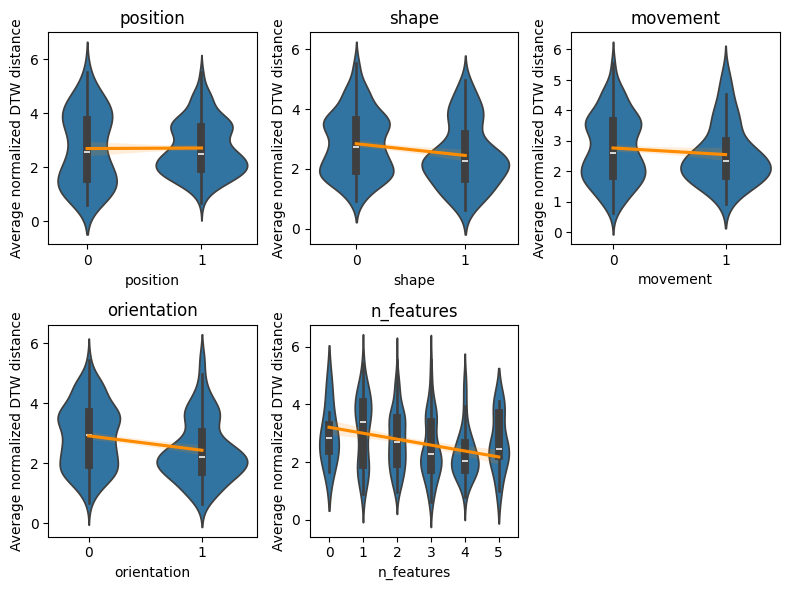

position: 0.026 (p-value: 0.608)
shape: -0.160 (p-value: 0.002)
movement: -0.079 (p-value: 0.117)
orientation: -0.220 (p-value: 0.000)
n_features: -0.221 (p-value: 0.000)


In [17]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_z.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

### 1.7.2 Position & size normalized data

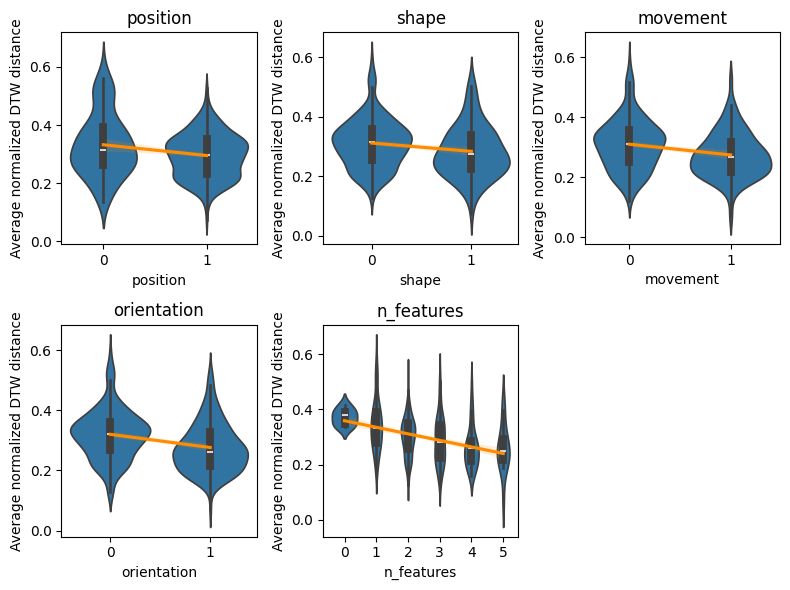

position: -0.123 (p-value: 0.015)
shape: -0.161 (p-value: 0.001)
movement: -0.179 (p-value: 0.000)
orientation: -0.278 (p-value: 0.000)
n_features: -0.327 (p-value: 0.000)


In [18]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

## 1.8 Summary
The results show that the correlation for all features are stronger for the **position & size normalized** data than for z-normalized data. Therefore, we will use the position & size normalized data for further analyses.

# 2. Original duration vs adjusted duration
Next, we will check if DTW can provide a stable prediction even if the gesture duration is very short (e.g., 5 frames). We compare the performance of DTW on the original gesture duration and adjusted duration. The adjustment is done only for gestures whose durations are shorter than 330 ms. For these short gestures, we added an equal interval before and after the gesture and elongated its duration to 330 ms (10 frames for 30fps).

## 2.1 Trim time series for gesture duration

In [26]:
### for adjusted duration data
MT_files = glob.glob(norm_smooth_folder + "*.csv")
ts_annot_adjusted_folder = ts_annot_folder + "adjusted/"
export_merge_annot(MT_files, anno, ts_annot_adjusted_folder, adj_dur=True)

Number of comparisons: 419


100%|██████████| 38/38 [00:00<00:00, 43.42it/s]

16 files skipped because they already exist
Files skipped: ['pair05_synced_ppA', 'pair05_synced_ppB', 'pair07_synced_ppA', 'pair07_synced_ppB', 'pair09_synced_ppA', 'pair09_synced_ppB', 'pair11_synced_ppA', 'pair11_synced_ppB', 'pair13_synced_ppA', 'pair13_synced_ppB', 'pair14_synced_ppA', 'pair14_synced_ppB', 'pair16_synced_ppA', 'pair16_synced_ppB', 'pair20_synced_ppA', 'pair20_synced_ppB']


## 2.2 Compute DTW distance

In [27]:
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
keypoints = retrieve_relative_keypoints()

output_filename = "dtw_distance_adjusted.csv"
make_export_dtw_df(dtw_folder, ts_annot_adjusted_folder, keypoints, anno, output_filename, dtw_type="independent")

100%|██████████| 838/838 [00:21<00:00, 38.20it/s] 

The follwing 13 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_ppA_375_both.csv', 'pair20_synced_ppA_376_right.csv', 'pair20_synced_ppA_377_right_left.csv', 'pair20_synced_ppA_378_right.csv']
(406, 77)


## 2.3 Evaluate the performance of DTW

Let's check if adjusting the gesture duration improves the predictive accuracy of DTW.

### 2.3.1 Original duration

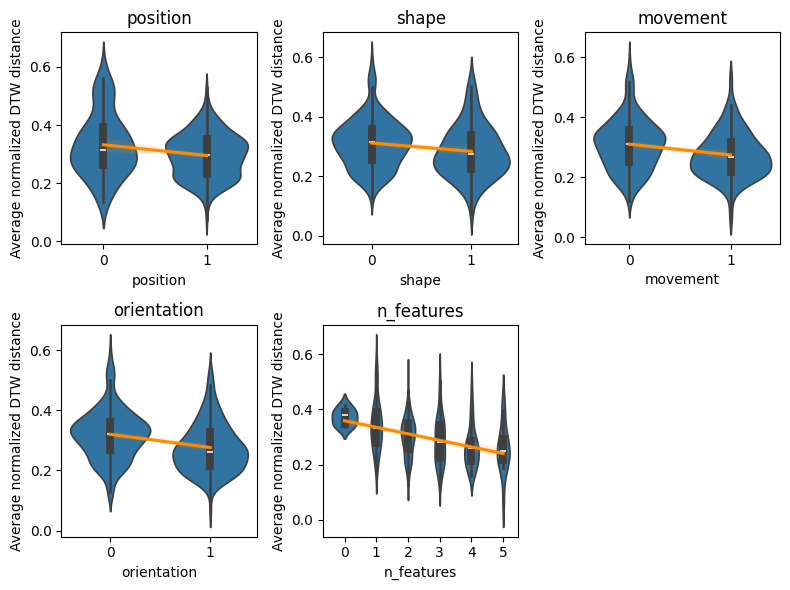

position: -0.123 (p-value: 0.015)
shape: -0.161 (p-value: 0.001)
movement: -0.179 (p-value: 0.000)
orientation: -0.278 (p-value: 0.000)
n_features: -0.327 (p-value: 0.000)


In [28]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

### 2.3.2 Adjusted duration

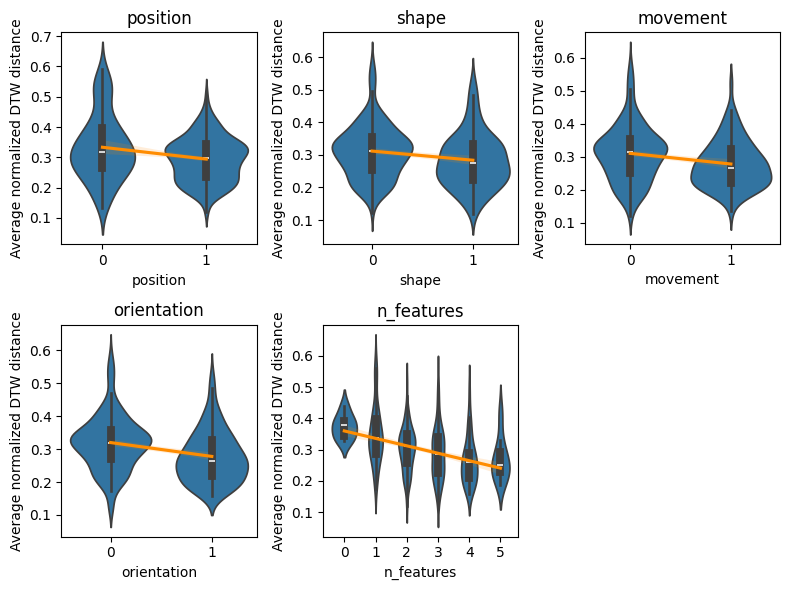

position: -0.133 (p-value: 0.007)
shape: -0.164 (p-value: 0.001)
movement: -0.171 (p-value: 0.001)
orientation: -0.270 (p-value: 0.000)
n_features: -0.334 (p-value: 0.000)


In [29]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_adjusted.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

## 2.4 Summary
Computing DTW on adjusted duration improved the correlation for position, handshape, and n_features, but the degree of improvement was tiny. As the difference is not very decisive, we will compare the predictive performance of DTW in the following four scenarios and choose the best performing one:

- symmetric DTW on original duration
- symmetric DTW on adjusted duration
- asymmetric, loose begin and end DTW on original duration
- asymmetric, loose begin and end DTW on adjusted duration

# 3. Symmetric vs Asymmetric DTW
Typically, gesture segmentation is performed by a human annotator who watches the video and decides the beginning and end of a gesture (stroke). As the beginning and end of a gesture is often not very clear, the segmentation of gesture strokes may not be perfectly accurate, and unreliable segmentation may significanly increase the distance. For details, please see [this paper](https://ieeexplore.ieee.org/document/7837974).

<img src="figures/silva.gif" height=300 />

One solution proposed by Silva et al. (2016) is to loosen the beginning & end constraints of DTW. Therefore, we will try if the asymmetric, open-begin and open-end DTW results in better predictions.

## 3.1 Compute DTW distance

In [32]:
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
keypoints = retrieve_relative_keypoints()

### asymmetric, original duration
output_filename = "dtw_distance_asym.csv"
make_export_dtw_df(dtw_folder, ts_annot_folder, keypoints, anno, output_filename, step_pattern="asymmetric", dtw_type="independent")

### asymmetric, adjusted duration
output_filename = "dtw_distance_asym_adjusted.csv"
ts_annot_adjusted_folder = ts_annot_folder + "adjusted/"
make_export_dtw_df(dtw_folder, ts_annot_adjusted_folder, keypoints, anno, output_filename, step_pattern="asymmetric", dtw_type="independent")

100%|██████████| 838/838 [00:16<00:00, 50.53it/s] 


The follwing 29 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['pair05_synced_ppA_23_left_right.csv', 'pair05_synced_ppA_28_left_right.csv', 'pair07_synced_ppA_38_both.csv', 'pair07_synced_ppA_46_both.csv', 'pair07_synced_ppA_76_both.csv', 'pair11_synced_ppA_126_right.csv', 'pair13_synced_ppA_132_both.csv', 'pair13_synced_ppA_133_both.csv', 'pair13_synced_ppA_134_both.csv', 'pair13_synced_ppA_136_both.csv', 'pair13_synced_ppA_137_both.csv', 'pair13_synced_ppA_138_both.csv', 'pair13_synced_ppA_142_both.csv', 'pair13_synced_ppA_161_both.csv', 'pair13_synced_ppA_237_both.csv', 'pair16_synced_ppA_341_both.csv', 'pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_p

100%|██████████| 838/838 [00:20<00:00, 41.60it/s] 

The follwing 13 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_ppA_375_both.csv', 'pair20_synced_ppA_376_right.csv', 'pair20_synced_ppA_377_right_left.csv', 'pair20_synced_ppA_378_right.csv']
(406, 77)


## 3.2 Evaluate the performance of DTW

### 3.2.1 Symmetric DTW on original duration

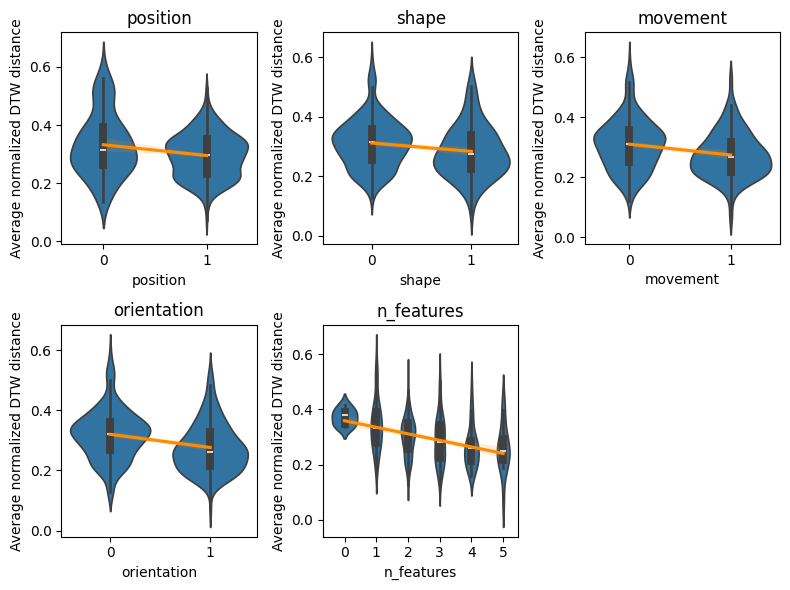

position: -0.123 (p-value: 0.015)
shape: -0.161 (p-value: 0.001)
movement: -0.179 (p-value: 0.000)
orientation: -0.278 (p-value: 0.000)
n_features: -0.327 (p-value: 0.000)


In [33]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

### 3.2.2 Symmetric DTW on adjusted duration

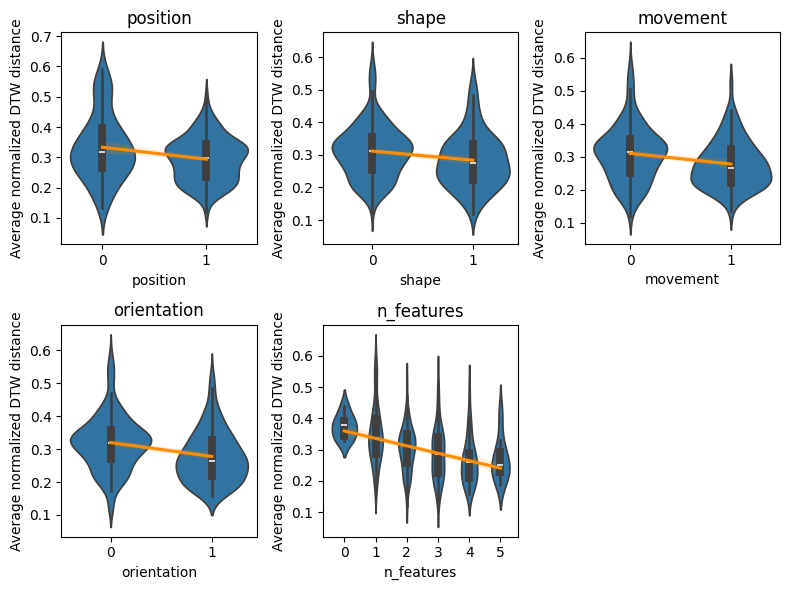

position: -0.133 (p-value: 0.007)
shape: -0.164 (p-value: 0.001)
movement: -0.171 (p-value: 0.001)
orientation: -0.270 (p-value: 0.000)
n_features: -0.334 (p-value: 0.000)


In [34]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_adjusted.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

### 3.2.3 Asymmetric DTW on original duration

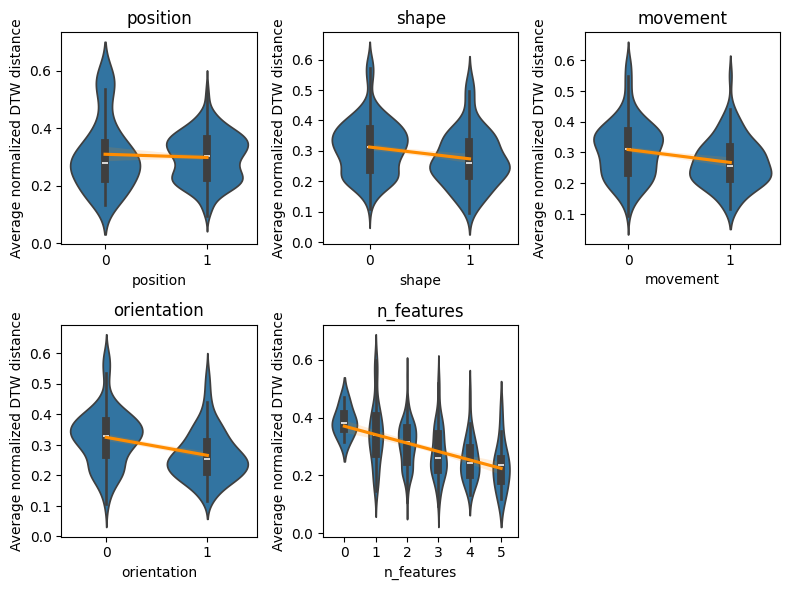

position: 0.027 (p-value: 0.601)
shape: -0.195 (p-value: 0.000)
movement: -0.190 (p-value: 0.000)
orientation: -0.331 (p-value: 0.000)
n_features: -0.351 (p-value: 0.000)


In [35]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_asym.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

### 3.2.4 Asymmetric DTW on adjusted duration

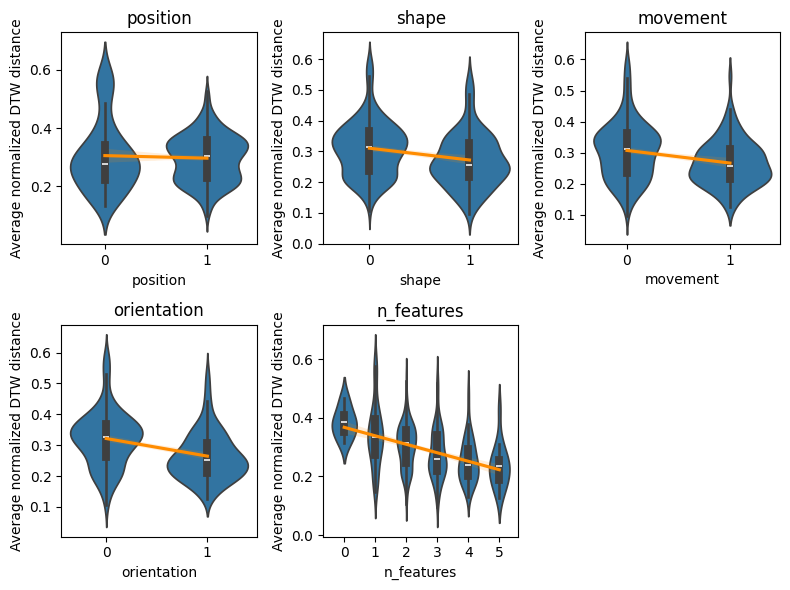

position: 0.037 (p-value: 0.454)
shape: -0.203 (p-value: 0.000)
movement: -0.195 (p-value: 0.000)
orientation: -0.332 (p-value: 0.000)
n_features: -0.361 (p-value: 0.000)


In [36]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_asym_adjusted.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

## 3.3 Summary
The **asymmetric, open-begin and open-end DTW on adjusted duration** yielded the highest predictive accuracy. It is worth noting that the asymmetric DTW boosted correlation for handshape, movement, orientation, and n_features, but the correlation for position became non-significant and even positive.

# 4. Independent vs Dependent DTW
Next, we will check whether dependent DTW (DTWd) works better than the "independent DTW (DTWi)". It is worth noting that our DTWi is not entirely independent; we compute DTWd for each keypoint and average them over. The averaging makes it "independent". In contrast, DTWd computes one distance score for all keypoints per hand.

## 4.1 Compute DTW distance

In [40]:
anno = pd.read_csv(anno_path + "gesture_form_similarity_coding_processed.csv")
keypoints = retrieve_relative_keypoints()

### DTWd
output_filename = "dtw_distance_dependent.csv"
ts_annot_adjusted_folder = ts_annot_folder + "adjusted/"
make_export_dtw_df(dtw_folder, ts_annot_adjusted_folder, keypoints, anno, output_filename, step_pattern="asymmetric", dtw_type="dependent")

100%|██████████| 838/838 [00:17<00:00, 49.07it/s] 

The follwing 13 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['pair20_synced_ppA_366_right.csv', 'pair20_synced_ppA_367_right.csv', 'pair20_synced_ppA_368_both.csv', 'pair20_synced_ppA_369_both.csv', 'pair20_synced_ppA_370_right.csv', 'pair20_synced_ppA_371_both.csv', 'pair20_synced_ppA_372_both.csv', 'pair20_synced_ppA_373_right.csv', 'pair20_synced_ppA_374_both.csv', 'pair20_synced_ppA_375_both.csv', 'pair20_synced_ppA_376_right.csv', 'pair20_synced_ppA_377_right_left.csv', 'pair20_synced_ppA_378_right.csv']
(406, 57)


## 4.2 Evaluate the performance of DTW

### 4.2.1 Independent DTW

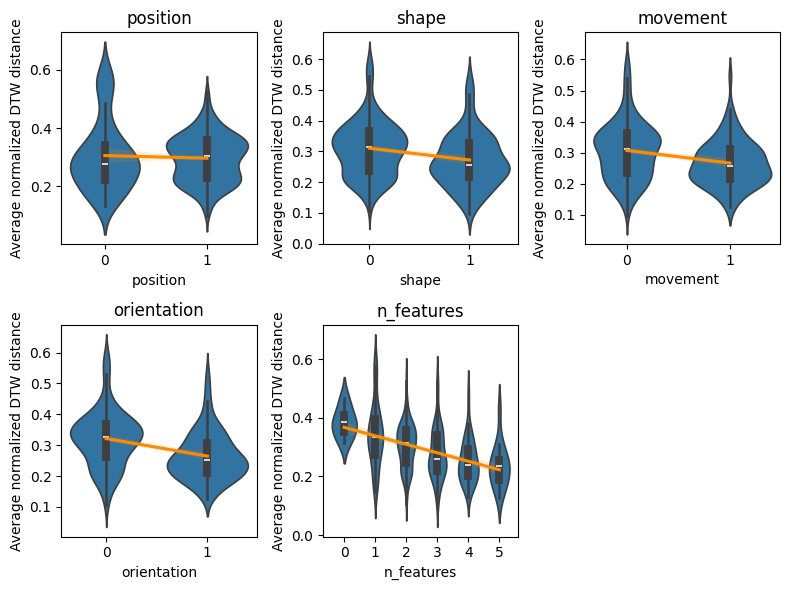

position: 0.037 (p-value: 0.454)
shape: -0.203 (p-value: 0.000)
movement: -0.195 (p-value: 0.000)
orientation: -0.332 (p-value: 0.000)
n_features: -0.361 (p-value: 0.000)


In [42]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_asym_adjusted.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

### 4.2.2 Dependent DTW

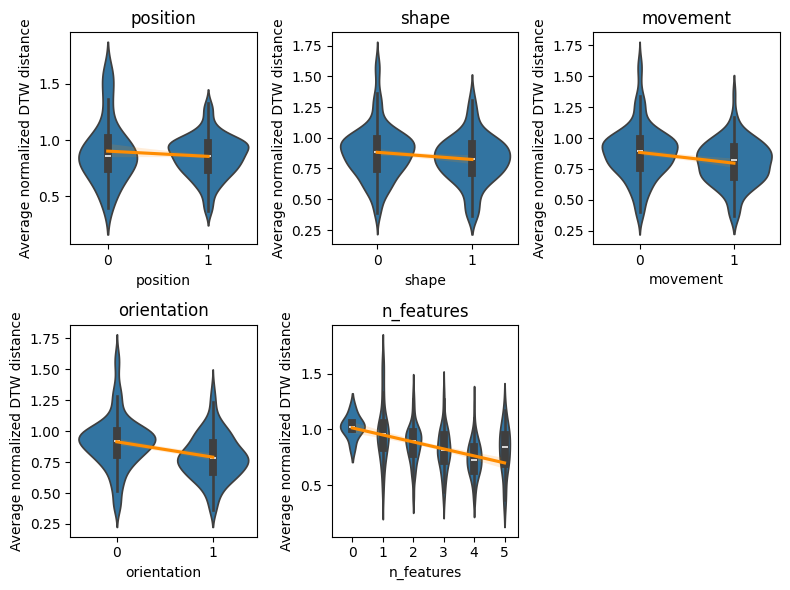

position: -0.018 (p-value: 0.715)
shape: -0.122 (p-value: 0.014)
movement: -0.176 (p-value: 0.000)
orientation: -0.313 (p-value: 0.000)
n_features: -0.347 (p-value: 0.000)


In [43]:
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_dependent.csv")

### plot the average distance for each feature
fig = plt.figure(figsize=(8, 6))
columns = 3
rows = 2
features = ["position", "shape", "movement", "orientation", "n_features"]
plot_dtw_sim(fig, columns, rows, features, df_dtw)

### compute correlations between DTW distances and feature similarities
for feature in features:
    corr, p_value = spearmanr(df_dtw["average_distance"], df_dtw[feature])
    print(f"{feature}: {corr:.3f} (p-value: {p_value:.3f})")

## 4.3 Summary
The results show that **independent DTW** offers a better prediction of gesture form similarity compared to dependent DTW. Therefore, we will use DTWi.

# 5. Summary of our approach

1. Apply position/size normalization instead of z-normalization.
1. Use the relative position between the wrist and a finger tip for DTW. This is to minimize the chance of inflating the distance due to different position (values). For example, imagine that we have front-view recordings for two speakers, and they produced the identical movements but in different positions. In this case, the pattern in ts will be identical, but the values will be different. As DTW is senstive not only to the pattern in ts but also the value itself, identical movements in different positions will be "penalized" and have a larger distance. This "penalty" will be multiplied if we use multiple joints, as each joint will be penalized, and the penalty adds up. By using the relative positions for each joints, only the wrist will be penalized.
1. Set the minimum duration as 330 ms (10 frames; 30 FPS). If the gesture stroke duration is less than 330ms, we will add equal interval before and after the stroke to make it 330ms long.
1. Only use the distance for gesturing hands when calculating the average distance.
1. Use asymmetric, loose beginning and end constraints DTW.